<a href="https://colab.research.google.com/github/SamDutse/Tranzactspomodel/blob/main/Intent_Recognition_and_Entity_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# loading the dataset:
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path to your dataset
file_path = '/content/drive/MyDrive/transaction_data.csv'

# Load the dataset
data = pd.read_csv(file_path)

# Display the first few rows
print(data.head())


Mounted at /content/drive
                          Command              Intent
0        Check my account balance       Check Balance
1              What's my balance?       Check Balance
2     Cancel the last transaction  Cancel Transaction
3  Pls transfer 2k to 07062883534          Send Money
4                      Plz cancel  Cancel Transaction


In [ ]:
# Data preprocessing:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Encode intents into numerical labels
label_encoder = LabelEncoder()
data['Intent_Label'] = label_encoder.fit_transform(data['Intent'])

# Tokenize and pad commands
max_words = 5000  # Maximum vocabulary size
max_len = 20      # Maximum sequence length

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(data['Command'])

sequences = tokenizer.texts_to_sequences(data['Command'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, data['Intent_Label'], test_size=0.2, random_state=42
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples: 800
Testing samples: 200


In [ ]:
# Building the model:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Ensure input_dim is correctly set to the vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # Include space for <OOV> token

# Build the model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Explicitly build the model by providing an input shape
model.build(input_shape=(None, max_len))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 20, 64)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,588 (154.64 KB)

 Trainable params: 39,588 (154.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=2
)

# Save the trained model
model.save("intent_recognition_model.keras")

Epoch 1/10
25/25 - 5s - 185ms/step - accuracy: 0.2375 - loss: 1.3887 - val_accuracy: 0.2000 - val_loss: 1.3842
Epoch 2/10
25/25 - 1s - 32ms/step - accuracy: 0.4900 - loss: 1.1138 - val_accuracy: 0.4650 - val_loss: 0.7465
Epoch 3/10
25/25 - 1s - 22ms/step - accuracy: 0.5000 - loss: 0.7174 - val_accuracy: 0.4800 - val_loss: 0.8294
Epoch 4/10
25/25 - 1s - 25ms/step - accuracy: 0.5113 - loss: 0.7118 - val_accuracy: 0.4750 - val_loss: 0.7027
Epoch 5/10
25/25 - 1s - 25ms/step - accuracy: 0.5238 - loss: 0.6962 - val_accuracy: 0.4650 - val_loss: 0.7017
Epoch 6/10
25/25 - 0s - 12ms/step - accuracy: 0.5312 - loss: 0.7055 - val_accuracy: 0.5350 - val_loss: 0.6884
Epoch 7/10
25/25 - 0s - 13ms/step - accuracy: 0.4675 - loss: 0.7076 - val_accuracy: 0.4650 - val_loss: 0.6954
Epoch 8/10
25/25 - 0s - 13ms/step - accuracy: 0.5000 - loss: 0.6977 - val_accuracy: 0.4750 - val_loss: 0.6994
Epoch 9/10
25/25 - 1s - 24ms/step - accuracy: 0.5063 - loss: 0.7593 - val_accuracy: 0.5300 - val_loss: 0.6685
Epoch 10/

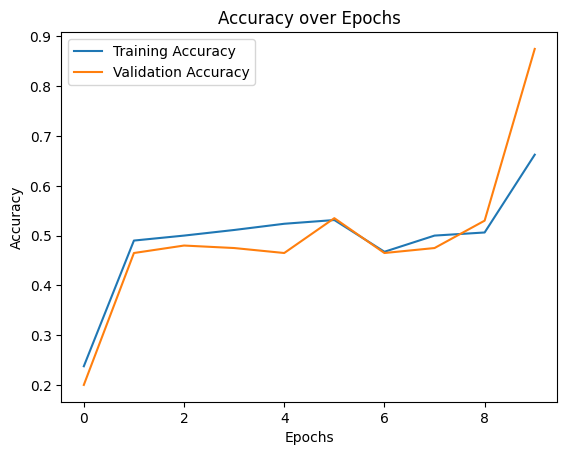

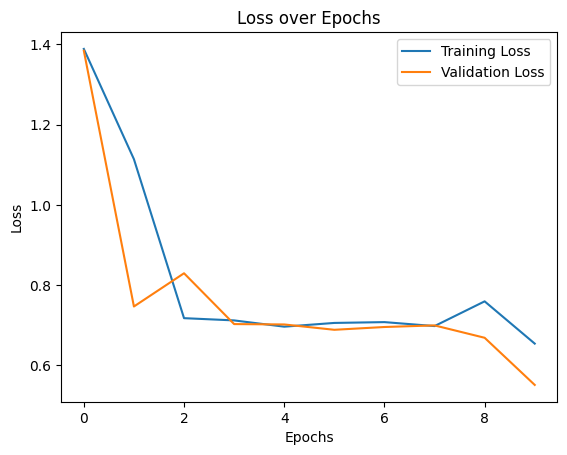

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Evaluate the Model:
from sklearn.metrics import classification_report

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

# Classification Report
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
                    precision    recall  f1-score   support

Cancel Transaction       0.68      1.00      0.81        53
     Check Balance       1.00      1.00      1.00        40
        Send Money       1.00      0.55      0.71        55
    Withdraw Money       1.00      1.00      1.00        52

          accuracy                           0.88       200
         macro avg       0.92      0.89      0.88       200
      weighted avg       0.92      0.88      0.87       200



In [ ]:
# Interactive Testing:
def predict_intent(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model.predict(padded)
    intent = label_encoder.inverse_transform([pred.argmax(axis=1)[0]])[0]
    return intent

# Test with a sample input
print(predict_intent("send 1000 to john"))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Send Money
